#### Etape 1 : Importer les librairies nécessaires pour notre modèle CNN

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping , TensorBoard
from tensorflow.keras.applications import VGG16

import numpy as np
import matplotlib.pyplot as plt

import pathlib
from pathlib import Path
import os

import imghdr
from PIL import Image
import cv2 

import itertools
import datetime

#### Etape 2 : Préparer l'envirronement de travail (activer l'accélération GPU)

In [2]:
def prepare_gpu_acceleration():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        print("GPU is AVAILABLE 🚀")
        print(tf.config.experimental.list_physical_devices('GPU'))
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print("An error occured while setting memory growth for GPU 💀")
            print(e)
    else:
        print("GPU is NOT AVAILABLE 🐌")
        print(tf.config.experimental.list_physical_devices())

prepare_gpu_acceleration()

GPU is AVAILABLE 🚀
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Etape 3 : Verification des données (enlever les images corrompues , et les images qui ne sont pas supportées par tensorflow)

In [3]:
# Définir les chemins vers les données
data_dir = 'data'

In [4]:
# Identifier le nombre de fichier dans le dataset
def file_counter():
    counter = {}
    for subdir, dirs, files in os.walk(data_dir):
        # si le repertoire est un répertoire de classe contient des images
        if len(files) > 0:
            # récuperer le nom de la classe
            class_name = os.path.basename(subdir)
            # compter le nombre d'images dans le dictionnaire
            count = len(files)
            # enregistrer le nombre d'images dans le dictionnaire
            counter[class_name] = count

    return counter


counter = file_counter()

print("Nombre de fichiers dans le dataset : ", len(list(pathlib.Path(data_dir).glob('*/*'))))
for class_name, count in counter.items():
    print(f"{class_name} : {count}")

Nombre de fichiers dans le dataset :  19986
Painting : 9993
Photo : 9993


In [5]:
# 📢 lancer la fonction une seule fois seulement pour vérifier les images

# Filtrage des elements non desirés
accepted_extensions = [".png", ".jpg", ".jpeg", ".bmp"]
corrupted_images_dir = "corrupted"

#deplacer les images corrumpu
def move_invalid_files(file, subdir):
    if not os.path.exists(corrupted_images_dir):
        os.mkdir(corrupted_images_dir)
    invalid_image_path = os.path.join(corrupted_images_dir, file)
    os.rename(os.path.join(subdir, file), invalid_image_path)

#verifier les images
def check_images():
    valid_count = 0
    invalid_count = 0
    count_by_class = {}
    for subdir, dirs, files in os.walk(data_dir):
        # si le repertoire est un répertoire de classe contient des images
        if len(files) > 0:
            for file in files:
                # récuperer le nom de la classe
                class_name = os.path.basename(subdir)
                if class_name not in count_by_class:
                    count_by_class[class_name] = {"valid": 0, "invalid": 0}
                # vérifier si l'extension du fichier est accepté
                if Path(file).suffix.lower() in accepted_extensions:
                    # vérifier si le fichier est une image valide
                    if imghdr.what(os.path.join(subdir, file)) is not None:
                        # check si les images ne sont pas corrompues
                        try:
                            img_bytes = tf.io.read_file(os.path.join(subdir, file))
                            decoded_img = tf.image.decode_image(img_bytes)
                            valid_count += 1
                            count_by_class[class_name]["valid"] += 1
                        except tf.errors.InvalidArgumentError as e:
                            invalid_count += 1
                            count_by_class[class_name]["invalid"] += 1
                            move_invalid_files(file, subdir)
                    else:
                        invalid_count += 1
                        count_by_class[class_name]["invalid"] += 1
                        move_invalid_files(file, subdir)
                else:
                    invalid_count += 1
                    count_by_class[class_name]["invalid"] += 1
                    move_invalid_files(file, subdir)
    return valid_count, invalid_count, count_by_class


# valid_count, invalid_count, count_by_class = check_images()
# print("🟢 valid images: ", valid_count)
# print("🔴 invalid count: ", invalid_count)
# for class_name, count in count_by_class.items():
#     print(class_name)
#     print(f"- {count['valid']} valid")
#     print(f"- {count['invalid']} invalid")


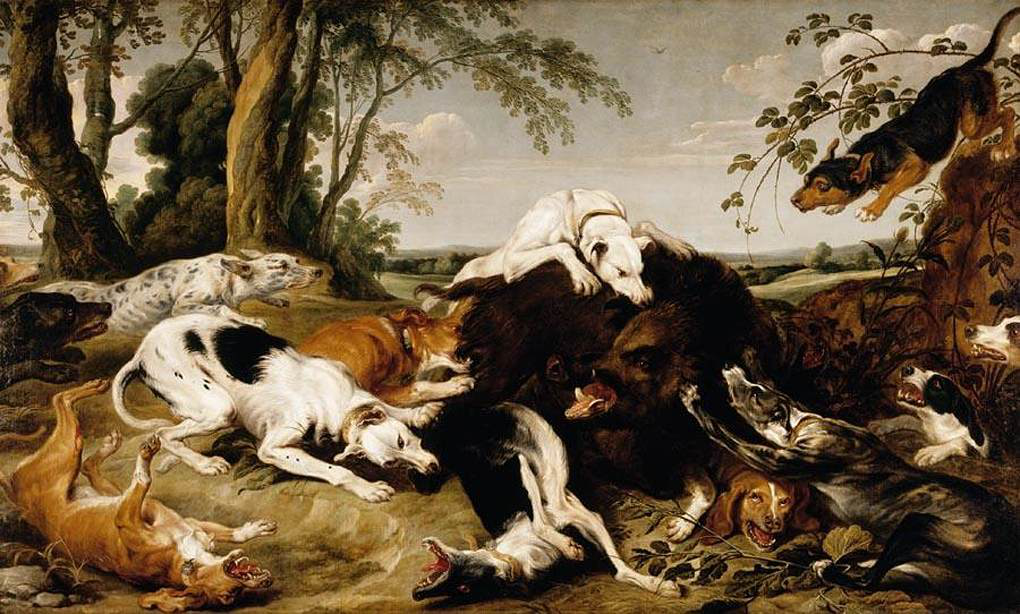

In [6]:
#afficher un echantillons du dataset
painting_images = list(pathlib.Path(data_dir).glob('Painting/*'))
random_painting = np.random.choice(painting_images, 1)
Image.open(str(random_painting[0]))

#### Etape 4 : Préparer les données d'entrainement et de test

In [7]:
# Initialiser les paramètres du modèle
RESCALING_FACTOR = 1./255
ROTAION_RANGE = 20, 
WIDTH_SHIFT_RANGE = 0.2
HEIGHT_SHIFT_RANGE = 0.2
SHEAR_RANGE = 0.2
ZOOM_RANGE = 0.2
HORIZONTAL_FLIP = True
VALIDATION_SPLIT = 0.2

IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_CHANNELS = 3
BACH_SIZE = 32

AUTOTUNE_SHUFFLE_BUFFER_SIZE = 1000

CLASS_MODE = "categorical"
LOSS_FUNCTION = "categorical_crossentropy"
LEARING_RATE = 0.001
METRICS = ["accuracy"]
EPOCHS = 15

In [8]:
# creer les générateurs d'images
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2 # 80% training and 20% validation
)


In [9]:
# Preparer les données d'entrainement et de validation
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Preparer les données de validation
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 15990 images belonging to 2 classes.
Found 3996 images belonging to 2 classes.


#### Etape 5 : Créer le modèle CNN

In [10]:
# Identifier les classes 
class_names = train_generator.class_indices
num_classes = len(class_names)
print(f"Total de classes ({num_classes}) - {class_names}")

Total de classes (2) - {'Painting': 0, 'Photo': 1}


In [11]:
# Creation du modéle de CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

In [12]:
# résumer le modéle
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

#### Etape 6 : Compilation et entrainement du modèle

In [13]:
# Compiler le modéle
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [14]:
model_filepath = f"models/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}/model.h5"
logs_dir = f"logs/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
# Définir les callbacks pour l'entrainement
callbacks = [
    # Définition de l'arret précoce pour éviter le sur-apprentissage
    EarlyStopping(
        monitor='val_loss', 
        patience=3
    ),
    # Validation croisée
    ModelCheckpoint(
        filepath=model_filepath,
        monitor='val_loss', 
        save_best_only=True
    ),
    # TensorBoard pour visualiser les courbes d'apprentissage
    TensorBoard(log_dir=logs_dir, histogram_freq=1)
]


In [15]:
# Entrainement du modéle
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/15
500/500 [==============================] - 373s 741ms/step - loss: 0.6231 - accuracy: 0.6702 - val_loss: 0.5306 - val_accuracy: 0.7610
Epoch 2/15
500/500 [==============================] - 364s 727ms/step - loss: 0.5092 - accuracy: 0.7587 - val_loss: 0.4883 - val_accuracy: 0.7825
Epoch 3/15
500/500 [==============================] - 362s 723ms/step - loss: 0.4637 - accuracy: 0.7876 - val_loss: 0.3981 - val_accuracy: 0.8326
Epoch 4/15
500/500 [==============================] - 361s 722ms/step - loss: 0.4279 - accuracy: 0.8113 - val_loss: 0.3994 - val_accuracy: 0.8261
Epoch 5/15
500/500 [==============================] - 354s 707ms/step - loss: 0.4058 - accuracy: 0.8240 - val_loss: 0.3864 - val_accuracy: 0.8401
Epoch 6/15
500/500 [==============================] - 355s 710ms/step - loss: 0.3779 - accuracy: 0.8385 - val_loss: 0.3390 - val_accuracy: 0.8511
Epoch 7/15
500/500 [==============================] - 358s 717ms/step - loss: 0.3653 - accuracy: 0.8453 - val_loss: 0.3541 -

#### Etape 7 : Evaluation du modèle

In [16]:
# Récupérer les données de l'historique
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

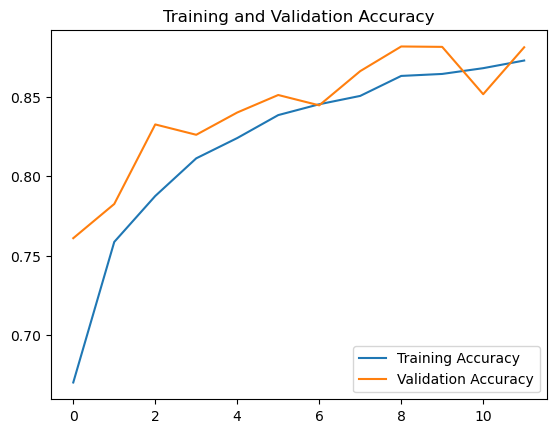

In [17]:
# Afficher les courbes de précision
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

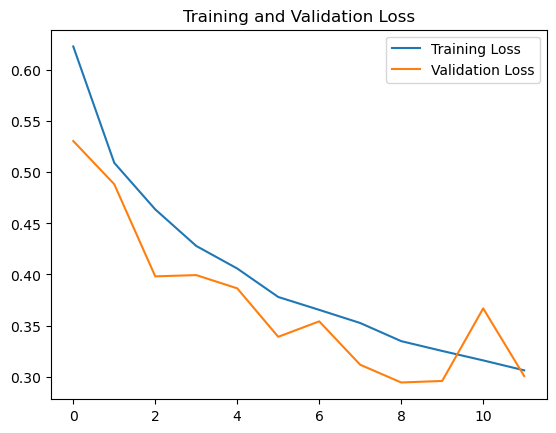

In [18]:
# Afficher les courbes de perte
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
def overfitting_underfitting(acc , val_acc , loss , val_loss):
   if acc[-1] > val_acc[-1] and loss[-1] < val_loss[-1]:
      print("The model is overfitting 🤮")
      print(f"Training accuracy : {acc[-1]*100:.2f}%")
      print(f"Validation accuracy : {val_acc[-1]*100:.2f}%")
   elif acc[-1] < val_acc[-1] and loss[-1] > val_loss[-1]: 
      print("The model is underfitting 🗿")
      print(f"Training accuracy : {acc[-1]*100:.2f}%")
      print(f"Validation accuracy : {val_acc[-1]*100:.2f}%")
   else:
      print("The model is perfect fit 🧠")
      print(f"Training accuracy : {acc[-1]*100:.2f}%")
      print(f"Validation accuracy : {val_acc[-1]*100:.2f}%")
      
overfitting_underfitting(acc , val_acc , loss , val_loss)

The model is underfitting 🗿
Training accuracy : 87.28%
Validation accuracy : 88.11%
